# Implementing clusters

Now that we can configure the FPGAs it is important understand how to interact with them.
To do so Python provides several tools.
One could continue using ```ascyncssh``` to send and retrieve data from the nodes.
This would prove combersome considering that synchronization between nodes would have be to solved by the user as well as the data transmission.
To simplify this I will demonstrate how to create an MPI cluster by relying on [IPython clusters](https://ipyparallel.readthedocs.io/en/latest/) and the JSON description of the system.

### basic_test

The block design for a basic test of the comblock usage in the hyperfpga.
    


![Basic Test](images/basic_test.png) 


In [14]:
import os
import sys
sys.executable
sys.path.insert(0, os.path.expanduser("~"))
sys.path.insert(0, os.path.expanduser("~/Comblock"))
from hyperfpga_conf.clusterconf import hyperfpga, get_nodes
import ipyparallel as ipp

Assigned Nodes:


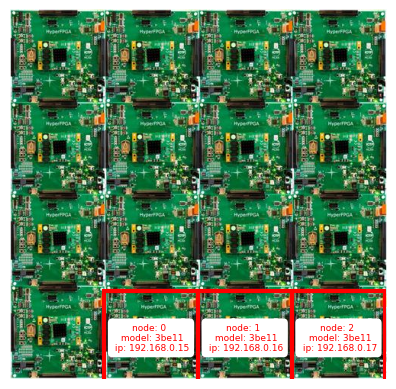

In [15]:
nodes = get_nodes()
testnode = [nodes[2]]

In [3]:

cluster = hyperfpga(testnode, 'SVC_2_SBTR' ,n_engines = len(testnode), engines_per_node = 1)
cluster.firmware

['SVC_2_SBTR']

Profile exists, rewritting configuration.
Uploading firmware...
b'/home/jupyter-torino-user/bitstreams/SVC_2_SBTR-3be11.dtbo' -> b'' 000.00.92
 Programming fpgas...
Time taken to load BIN is 183.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully

 Node Status


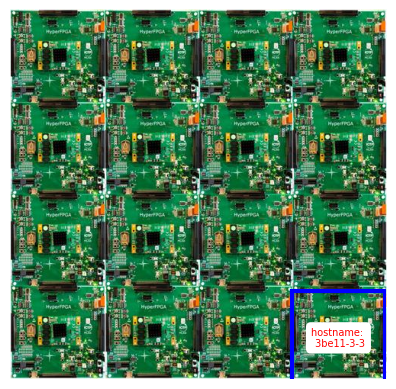

 host: hyperfpga-3be11-3-3 state: operating
 firmware: SVC_2_SBTR comblock: ['fifo_i', 'fifo_o', 'ram', 'regs_i', 'regs_o', 'regs_i', 'regs_o']



In [4]:
cluster.create_profile()
await cluster.configure()

In [5]:
rc = cluster.start_and_connect_sync()

Starting 1 engines with <class 'ipyparallel.cluster.launcher.SSHEngineSetLauncher'>
ensuring remote mlabadm@192.168.0.17:.ipython/profile_ssh/security/ exists
sending /home/jupyter-torino-user/.ipython/profile_ssh/security/ipcontroller-1746536576-obcw-client.json to mlabadm@192.168.0.17:.ipython/profile_ssh/security/ipcontroller-1746536576-obcw-client.json
ensuring remote mlabadm@192.168.0.17:.ipython/profile_ssh/security/ exists
sending /home/jupyter-torino-user/.ipython/profile_ssh/security/ipcontroller-1746536576-obcw-engine.json to mlabadm@192.168.0.17:.ipython/profile_ssh/security/ipcontroller-1746536576-obcw-engine.json
Running `python3 -m ipyparallel.engine --profile-dir=/home/mlabadm/.ipython/profile_ssh`
100%|██████████| 1/1 [00:09<00:00,  9.99s/engine]


In [6]:
print(rc[0])

<DirectView 0>


# Interacting with the Hardware

At this point you can interact with your generated hardware via 

In [7]:
import numpy as np
from PIL import Image
import math
import time
from fault_inj_helper import fi_sbtr_config

In [8]:
dview = rc[:]

with dview.sync_imports():
    import os
    from struct import unpack
    from comblock import Comblock

asyncresult=dview.apply(fi_sbtr_config, [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
print(asyncresult.get())

importing os on engine(s)
importing unpack from struct on engine(s)
importing Comblock from comblock on engine(s)


NameError: name 'fi_sbtr_config' is not defined

In [17]:
dview = rc[:]
print(dview)
with dview.sync_imports():
    import os
    from struct import unpack
    from comblock import Comblock


@dview.remote(block=True)
def finj_task(input_data,f_list=[],fi_config={}):
    def parse_fault(fi_config={},fault=[]):
        fault_list_name= fi_config.get("FAULT_LIST_NAME", "fault_list.txt")
        fault_model = fi_config.get("FAULT_MODEL","S@")
        F_sim_report = fi_config.get("F_SIM_REPORT", "simulation_report.csv")
        max_num_inj = fi_config.get("MAX_NUM_INJ", -1)
        num_target_components = fi_config.get("NUM_TARGET_COMPONENTS", 1)
        total_bit_shift = fi_config.get("TOTAL_BIT_SHIFT", 0)
        fi_structure = {
            "modules": num_target_components,  # 
            "sr_lenght": total_bit_shift,  # 
            "f_model": 3,  # fault model: 0-> stuck-at-0, 1: stuck-at-1, 2: bit-flip
            "component": 0,
            "start_bit_pos": 0,
            "end_bit_pos": 0,
            "bit_pos": 0,
            "seu_time": 0,
        }
    
        if len(fault)!=0:
            fi_structure["component"] = int(fault[0])
            fi_structure["start_bit_pos"] = int(fault[3])
            fi_structure["end_bit_pos"] = int(fault[4])
            fi_structure["bit_pos"] = int(fault[5])
            fi_structure["f_model"] = int(fault[6])
            fi_structure["seu_time"] = int(fault[7])
        return(fi_structure)
        
    def create_fault_descriptor(fi_structure):
        modules = fi_structure["modules"]
        sr_leght = fi_structure["sr_lenght"]
        component = fi_structure["component"]
        start_bit_pos = fi_structure["start_bit_pos"]
        end_bit_pos = fi_structure["end_bit_pos"]
        bit_pos = fi_structure["bit_pos"]
        f_cntrl = fi_structure["f_model"]
        seu_time = fi_structure["seu_time"]
        f_descriptor=[]
        f_descriptor.append(f_cntrl)
        f_descriptor.append(modules)
        f_descriptor.append(component)
        f_descriptor.append(sr_leght)
        f_descriptor.append(seu_time)
        f_descriptor.append(start_bit_pos)
        f_descriptor.append(end_bit_pos)
        for idx in range(fi_structure["sr_lenght"]):
            absolute_bit_pos = bit_pos + start_bit_pos
            if idx>= start_bit_pos and idx < end_bit_pos:
                if idx == absolute_bit_pos:
                    f_descriptor.append(1)
                else:
                    if idx == end_bit_pos-2:
                        f_descriptor.append(f_cntrl&1)
                        f_cntrl = f_cntrl >> 1
                    elif idx == end_bit_pos -1:
                        f_descriptor.append(f_cntrl&1)
                        f_cntrl = f_cntrl >> 1
                    else:
                        f_descriptor.append(0)                               
            else:
                f_descriptor.append(0)
        return(f_descriptor)
                    
    def sim_cb(image):
        cb0 = Comblock(0)
        def reset_SVC(cb):
            cb.write_reg(0,0)  # Reset the accelerator and clear the Comblock FIFO
            cb.write_reg(0,0xffffffff)  # Release reset 
        
        def reset_fifo_in_out(cb):
            cb.fifo_in_clear()
            cb.fifo_out_clear()
    
        def read_check_fifo_output(cb,list_inout):
            rd_fl= cb.fifo_in_elements()
            if rd_fl!=0:
                list_inout.append(cb.read_fifo(rd_fl))
            (data, elements, bit_over_flow, bit_almost_full, bit_full)=cb.fifo_out_status()
            return(elements, bit_almost_full)
        Read_fifo=[]
        cnt=0
        b=0;
        e=0
        t=len(image)
        try:
            reset_SVC(cb0)
            reset_fifo_in_out(cb0)
            for pixels in image:
                (elements, bit_almost_full)=read_check_fifo_output(cb0,Read_fifo)
                while(bit_almost_full):
                    (elements, bit_almost_full)=read_check_fifo_output(cb0,Read_fifo)
                b=e
                e=b+(1024-elements)
                if e<t and b<t:
                    cb0.write_fifo(image[b:e])
                elif b<t and e>=t:
                    cb0.write_fifo(image[b:t])
                else:
                    (elements, bit_almost_full)=read_check_fifo_output(cb0,Read_fifo)
                    break
        finally:
            print("got here")
        return Read_fifo

    def fi_sbtr_config(fault_descriptor):
        def fi_port_conf(cb,RSTN=0, TFEN=0, SREN=0):
            FI_PORT = ((RSTN<<2)|(TFEN<<1)|(SREN))
            cb.write_reg(0,FI_PORT)
        def clk_gen(cb,PORT):
            PORT=PORT^(1<<3)
            cb.write_reg(0,PORT)
            PORT=PORT^(1<<3)
            cb.write_reg(0,PORT)
        cb1 = Comblock(1)
        # 0 -> SREN
        # 1 -> TFEN
        # 2 -> RSTN
        # 3 -> CLK not from here
        RSTN=0
        TFEN=0
        SREN=0
        SI=0
        FI_PORT = ((SI<<4)|(RSTN<<2)|(TFEN<<1)|(SREN))
        cb1.write_reg(0,FI_PORT)
        clk_gen(cb1,FI_PORT)
        RSTN=1
        TFEN=0
        SREN=0
        SI=0
        FI_PORT = ((SI<<4)|(RSTN<<2)|(TFEN<<1)|(SREN))
        for _ in range(10):
            clk_gen(cb1,FI_PORT)
        for element in fault_descriptor[7:]:
            RSTN=1
            TFEN=0
            SREN=1
            SI=element
            FI_PORT = ((SI<<4)|(RSTN<<2)|(TFEN<<1)|(SREN))
            clk_gen(cb1,FI_PORT)
        RSTN=1
        TFEN=1
        SREN=0
        SI=0
        FI_PORT = ((SI<<4)|(RSTN<<2)|(TFEN<<1)|(SREN))
        for _ in range(2):
            clk_gen(cb1,FI_PORT)

    Result={}

    if len(f_list)!=0:
        for idx,fault_info in enumerate(f_list):
            fi_structure=parse_fault(fi_config=fi_config,fault=fault_info)
            f_descriptor=create_fault_descriptor(fi_structure)
            fi_sbtr_config(f_descriptor)
            resp_faulty = sim_cb(input_data)
            Result[idx]=resp_faulty
    else:
        fi_structure=parse_fault(fi_config=fi_config,fault=[])
        f_descriptor=create_fault_descriptor(fi_structure)
        fi_sbtr_config(f_descriptor)
        resp_faulty = sim_cb(input_data)
        resp_faulty = sim_cb(input_data) # just the first time in the golden sim
        Result[0]=resp_faulty
    return(Result)


<DirectView [0]>
importing os on engine(s)
importing unpack from struct on engine(s)
importing Comblock from comblock on engine(s)


In [10]:
def load_stereo_image(image):
    D=64
    Wc=7
    Wh=13
    M=450
    
    Left_image = np.array(Image.open(f"./dataset/{image}L.png").convert('L'))
    Right_image = np.array(Image.open(f"./dataset/{image}R.png").convert('L'))
    
    im_shape=Left_image.shape
    if len(im_shape)<3:
        (N_filas, N_columnas)=im_shape
        num_channels = 0
    else:
        (N_filas, N_columnas, num_channels)=im_shape
    
    print(im_shape)
    
    concat_images = []

    EN=1
    
    for i in range(0,N_filas):
        for j in range(0,M):
            if j<N_columnas:
                if num_channels!=0:
                    comp_pixel = (int(EN)<<16) | (int(Right_image[(i,j,0)])<<8) | int(Left_image[(i,j,0)])
                    concat_images.append(comp_pixel)
                else:
                    comp_pixel = (int(EN)<<16) | (int(Right_image[(i,j)])<<8) | int(Left_image[(i,j)])
                    concat_images.append(comp_pixel)
            else:
                concat_images.append((int(EN)<<16) | 0)
                
        
    for i in range(0,30*M): #(10*N_columnas+N_columnas*N_filas):(10*N_columnas+N_columnas*N_filas+10*N_columnas)
        concat_images.append((int(EN)<<16) | 0)
    #print(concat_images)
    return(concat_images,N_filas)

def write_disparity_result(resp,N_filas,mode="golden"):
    D=64
    Wc=7
    Wh=13
    M=450
    Output_image=np.zeros((N_filas, M, 3))
    
    flat_list = []
    for xs in resp:
        for xx in xs:
            flat_list.append(xx)
    csv_out=[]
    i=0
    j=0
    for k in range(0,len(flat_list)):
        tmp=flat_list[k]
        valid_pixel = ((tmp & 0x80)>>7)
        val=tmp & 0x7f
        if valid_pixel==1:
            Output_image[(i,j,0)]=(val)
            Output_image[(i,j,1)]=(val)
            Output_image[(i,j,2)]=(val)
            csv_out.append(val)
            j=j+1
            if j==M:
                j=0
                i=i+1
                if i==N_filas:
                    i=N_filas-1
    print(Output_image.max())
    
    Output_image[Output_image>=64]=0
    result=Output_image*255/(Output_image.max())
    output_file=result.astype(np.uint8)
    im = Image.fromarray(output_file, mode="RGB")
    im.save(f"./logs/Disparity_map_FPGA_{mode}.png")
    with open(f"./logs/Disparity_file_{mode}.csv","w") as fileo:
        for item in csv_out:
            fileo.write(f"{item}\n")

def main():    
    FAULT_MODEL="S@"
    F_LIST_NAME="fault_list.csv"
    F_INJ_REPORT="finj_report.csv"
    MAX_NUM_INJ=1
    NUM_JOBS=1
    CHUNK_SIZE=50

    os.system("mkdir -p logs")
    
    fi_infrastructure=load_fi_infrastructure("stereo_match_fi_infrastructure.json")
    num_target_components=len(fi_infrastructure)
    fault_list=read_fault_list(f"{FAULT_MODEL}_{F_LIST_NAME}")
    total_bit_shift = int(fault_list[-1][4])

    
    fi_config = {
        "FAULT_LIST_NAME": f"{FAULT_MODEL}_{F_LIST_NAME}",
        "FAULT_MODEL": f"{FAULT_MODEL}",
        "F_SIM_REPORT": f"{F_INJ_REPORT}",
        "MAX_NUM_INJ": MAX_NUM_INJ,
        "NUM_TARGET_COMPONENTS": num_target_components,
        "TOTAL_BIT_SHIFT": total_bit_shift,
        "JOBS": NUM_JOBS
    }
    
    (input_stereo_images, N_filas)=load_stereo_image("Cones")
    s_time=time.time()
    resp_golden=finj_task(input_stereo_images,f_list=[],fi_config=fi_config)
    e_time=time.time()
    print(f"fi_time={e_time-s_time}---------------------")
    write_disparity_result(resp_golden[0][0],N_filas,mode="golden")

    f_index=len(read_finj_report(f"{FAULT_MODEL}_{F_INJ_REPORT}"))
    
    
    for idx in range(f_index,len(fault_list),CHUNK_SIZE):
        s_time=time.time()
        fault_info=fault_list[idx:idx+CHUNK_SIZE]
        resp_faulty=finj_task(input_stereo_images,f_list=fault_info,fi_config=fi_config)
        e_time=time.time()
        print(f"fi_time={e_time-s_time}---------------------")
        for keys in resp_faulty[0].keys():
            key=int(keys)
            result_sim="Masked"
            if resp_golden[0][0]!=resp_faulty[0][keys]:
                write_disparity_result(resp_faulty[0][keys],N_filas,mode=f"fault_{idx+int(key)}")
                result_sim="SDC"
            result = f"{fault_info[key][0]},{fault_info[key][1]},{fault_info[key][2]},{fault_info[key][3]},{fault_info[key][4]},{fault_info[key][5]},{fault_info[key][6]},{fault_info[key][7]},{result_sim}\n"
            write_finj_report(f"{FAULT_MODEL}_{F_INJ_REPORT}",result)
        if idx>=MAX_NUM_INJ and MAX_NUM_INJ>=0:
            break

if __name__=='__main__':
    main()

(375, 450)
fi_time=3.3839328289031982---------------------
63.0
fi_time=87.05127215385437---------------------
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
63.0
0.0


/tmp/ipykernel_93487/4036251283.py:73: RuntimeWarning: invalid value encountered in divide
  result=Output_image*255/(Output_image.max())
/tmp/ipykernel_93487/4036251283.py:74: RuntimeWarning: invalid value encountered in cast
  output_file=result.astype(np.uint8)


0.0
0.0
0.0
0.0
0.0


In [11]:
rc.shutdown()
cluster.clean_cluster()
cluster.stop_cluster()

/tmp/ipykernel_93487/2632120412.py:2: RuntimeWarning: coroutine 'hyperfpga.clean_cluster' was never awaited
  cluster.clean_cluster()


<coroutine object Cluster.stop_cluster at 0x716bd41174c0>

In [12]:
cluster.reboot_cluster()

<coroutine object hyperfpga.reboot_cluster at 0x716bd4117bc0>